### **Diffusion!**

![](https://raw.githubusercontent.com/okarthikb/diffusion/main/diffusion.png)

Unconditional DDPM training and sampling algorithm from Ho et al. We implement the batched and conditional variant of these algorithms.

Relevant papers, blogs, and videos (first 8 important):

1. [Tutorial: Deriving the Standard Variational Autoencoder (VAE) Loss Function](https://arxiv.org/abs/1907.08956)
2. [Understanding Diffusion Models: A Unified Perspective](https://arxiv.org/abs/2208.11970) (detailed paper, goes through the entire derivation; discusess SNR and score-based interpretation of diffusion models, along with classifier-free guidance)
3. [Denoising diffusion probabilistic models from first principles](https://liorsinai.github.io/coding/2022/12/03/denoising-diffusion-1-spiral.html#reverse-process) (blog, ignore the Julia code, relevant section is derivation of functional form of forward process posterior, i.e., $q(x_{t - 1}\,|\,x_t, x_0)$)
4. [Tutorial on Denoising Diffusion-based Generative Modeling: Foundations and Applications](https://www.youtube.com/watch?v=cS6JQpEY9cs&t=2010s) (video, pretty long, just most of the contents above in video form)
5. [Proof: Kullback-Leibler divergence for the multivariate normal distribution](https://statproofbook.github.io/P/mvn-kl.html) (important proof, required to get the closed-form expression for reverse diffusion objective)
6. [DDPMs](https://arxiv.org/abs/2006.11239) (the Ho et al. paper)
7. [Improving DDPMs](https://arxiv.org/abs/2102.09672) (introduces cosine schedule and learnable variances for reverse diffusion)
8. [DDIMs](https://arxiv.org/abs/2010.02502) (nice trick to speed up diffusion inference)
9. [Generative Modeling by Estimating Gradients of the Data Distribution](https://yang-song.net/blog/2021/score/) (blog by Yang Song, a good primer on score functions and score-based generative modelling; idea discovered independently from diffusion, connection with diffusion models [later realized](https://www.quantamagazine.org/the-physics-principle-that-inspired-modern-ai-art-20230105/)\)
10. [MIT 6.S192 - Lecture 22: Diffusion Probabilistic Models, Jascha Sohl-Dickstein](https://www.youtube.com/watch?v=XCUlnHP1TNM&t=1016s) (original diffusion paper author lecture)
11. [Grokking Diffusion Models](https://nonint.com/2022/10/31/grokking-diffusion-models/) (this is re various ways to look @ diffusion models)
12. [Iterative 𝛼-(de)Blending: a Minimalist Deterministic Diffusion Model](https://ggx-research.github.io/publication/2023/05/10/publication-iadb.html) (viewing diffusion models from an image processing POV)
13. [On the Theory of Stochastic Processes, with Particular Reference to Applications](https://projecteuclid.org/ebooks/berkeley-symposium-on-mathematical-statistics-and-probability/Proceedings-of-the-First-Berkeley-Symposium-on-Mathematical-Statistics-and/chapter/On-the-Theory-of-Stochastic-Processes-with-Particular-Reference-to/bsmsp/1166219215.pdf) (old 1949 paper, relevant to equivalence of forward and reverse diffusion functional forms)
14. [What are Diffusion Models?](https://www.youtube.com/watch?v=fbLgFrlTnGU&t=251s) (the video referencing the paper above)

### tl;dr of diffusion

We train a generative model by estimating the data distribution so we can sample a new datapoint from the estimated distribution. One way to do this is to map every data point to a standard Gaussian using some process $q$, then using a neural net to learn the reverse map $p_{\theta}$. To generate a new data point, we just input Gaussian noise into $p_{\theta}$. The _forward diffusion_ process corrupts a data point by adding noise to it iteratively over $T$ timesteps. Formally, the distribution of a data point at timestep $t$ - $x_t$ - is defined as

$$q(x_t\,|\,x_{t - 1}) = \mathcal{N}\left(x_t\,;\,\mu = \sqrt{\bar\alpha_t}\,x_{t - 1},\;\sigma^2 = \sqrt{1 - \bar\alpha_t}\,I\right)$$

where $\bar\alpha_t$ and $1 - \bar\alpha_t$ approach 0 and 1 respectively as $t$ approches infinity, i.e., the distribution of the data point at the $t$th timestep approaches a standard normal distribution as $t$ approaches infinity. The forward process follows a variance schedule $\{\beta_t\}_{t=1}^{t=T}$, and we define $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{i = 1}^t\alpha_i$. We'd like to learn

$$q(x_{t - 1}\,|\,x_t) = \frac{q(x_t\,|\,x_{t - 1})\,q(x_{t - 1})}{q(x_t)} \tag{Bayes' theorem}$$

i.e., the reverse distribution, so we can start at $x_T \sim \mathcal{N}(0, 1)$ and iteratively denoise to get $x_0$ and hopefully $x_0$ is likely to be from the data distribution. One can prove that the equation for the reverse process is also a Gaussian with the following functional form

$$q(x_{t - 1}\,|\,x_t) = \mathcal{N}\left(x_{t - 1}\,;\,\mu=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{\beta_t}{\sqrt{1 - \bar\alpha_t}}\epsilon\right),\;\sigma^2=\tilde\beta_t\,I\right)$$

where $\epsilon$ is the noise that was sampled from $\mathcal{N}(0, I)$ and used to get $x_t$ using the reparametrization trick (i.e., the noise that was used to corrupt the initial data point $x_0$ to get $x_t$). $\{\tilde\beta_t\}_{t=1}^{t=T}$ is the reverse process variance schedule. Our reverse process must have the same functional form, and here we use a neural net $\epsilon_{\theta}$ to predict the noise $\epsilon$. The forward process mean is

$$\mu_q(x_t, t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{\beta_t}{\sqrt{1 - \bar\alpha_t}}\epsilon\right)$$

and the reverse process mean

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{\beta_t}{\sqrt{1 - \bar\alpha_t}}\epsilon_\theta(x_t, t)\right)$$

where have substituted the $\epsilon$ with our model $\epsilon_\theta$. Since our goal is to learn the reverse process, the objective function becomes the KL divergence between the actual reverse distribution and the predicted distribution at each timestep

$$L(\theta) = \mathbb{E}_{t\,\sim\,U(1,\,T),\,x_0\,\sim\,q(x_0),\,x_t\,\sim\,q(x_t\,|\,x_0)}\left[D_{KL}(q(x_{t - 1}\,|\,x_t)\,||\,p_{\theta}(x_{t - 1}\,|\,x_t))\right]$$

and this objective we minimize. Both the distributions are Gaussians, and the KL divergence between two Gaussians has a closed form. Here it reduces to simply being the mean squared error between the true nose $\epsilon$ and the model predicted noise $\epsilon_{\theta}(x_t, t)$ - which is very convenient!

The training algorithm then becomes: until convergence, choose a batch of images from the dataset, choose a timestep at random for each image, sample Gaussian noise $\epsilon$ for each image (the true noise that will be added), compute $x_t$ for each image using the reparametrization trick and the sampled noise ($x_t$ is the $x$ corrupted, corrupted using $\epsilon$), compute $\epsilon_{\theta}(x_t, t)$ (the noise predicted by the model), and backprop after computing the MSE loss between true and predicted noise.

The paper [here](https://arxiv.org/abs/2208.11970) and my notes [here](https://okarthikb.github.io/site/blog/diffusion.pdf) go over all this in more detail.

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
import torch, torchvision, matplotlib
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch import einsum
from torch.optim import Adam
from torchvision import datasets, transforms
from einops import rearrange, repeat
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
from IPython.display import HTML

### U-Net

![](https://raw.githubusercontent.com/okarthikb/diffusion/main/U-Net.png)

What we do with the U-Net:

1. The input is a batch of images `x` of shape `(batch_size, 1, 28, 28)`, timesteps `t` of shape `(batch_size,)` (each image in the batch is from a different timestep in the forward diffusion process), and classes `classes` of shape `(batch_size,)` (this is for class conditioned generation; here it's a tensor of integers from 0 to 9, i.e., 10 classes).
2. The output is also a batch of the same shape `(batch_size, 1, 28, 28)` as the input (see diagram above), and it's simply the model's predicted noise values for all pixels.
3. We generate position embeddings of shape using the function defined below - `position_embeddings(l, d)` - which takes in `l` (which is the sequence length in language modelling whereas here it's the number of timesteps) and `d` (which is is the dimension the embedding).
4. Set the time and class embedding dimension to 4 x image width/height (assuming a square image here). For inputs `t` and `classes` both of shape `(batch_size,)`, the embedding input will be of shape `(batch_size, 4 * x_size)`.
5. The time embedding layer is not learned. It's prespecified and is of shape `(T, t_emb_d=4 * x_size)`. During training, we choose `batch_size` timesteps at random from 1 to T, then get the embedding for each timestep to make the time embedding input of shape `(batch_size, t_emb_d)`. This is what tells the model the forward diffusion timesteps for which it needs to predict noise values.
6. The class embedding _is_ learned. We have 10 classes (digits from 0 to 9), so we create an embedding layer of shape `(n_class, class_emb_d)`. During training, for `batch_size` images, we receive `batch_size` classes (the label for each image) and we get the associated embedding for each class and form the class embedding input of shape `(batch_size, class_emb_d)`. Both `class_emb_d` and `t_emb_d` are the same.
7. Each `Conv2d` or `ConvTranspose2d` layer has a specific number of input and output channels (an RGB image as 3 channels). We project the time and class embeddings from their dimension to the channel dimension (i.e., `in_channels` or the number of input channels) and add the same projection along the channel dimension at every height-width index.
8. After each convolution block, we get an output of shape `(batch_size, n_channel, height, width)`. We reduce it to `(batch_size, n_channel, height * width)`, do self attention, and reshape to original shape.

If you don't know what position embeddings are, check out [this](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) very neat post on the topic.

If you're not upto speed on einsum/einops notation, check out [this](https://rockt.github.io/2018/04/30/einsum) post on einsum by Tim Rocktäschel and [this](https://einops.rocks/1-einops-basics/) tutorial on einops. [Some examples](https://einops.rocks/pytorch-examples.html) showing why einops is very convenient.

You don't have to read the linked sources for this tutorial; it suffices to know what the input and output of the U-Net are.

In [ ]:
def position_embeddings(l, d):
  w = 1e-4 ** (repeat(torch.arange(2, d + 2, 2), 'l -> (l 2)') / d)
  t = repeat(torch.arange(1, l + 1), 'l -> l d', d=d)
  pos = w * t
  pos[:, ::2], pos[:, 1::2] = torch.sin(pos[:, ::2]), torch.cos(pos[:, 1::2])
  return pos

In [ ]:
def conv_down_up(
  x_size, in_channels, out_channels, kernel_size, stride, padding
):
  down = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
  y_size = (x_size + 2 * padding - (kernel_size - 1) - 1) // stride + 1
  out_padding = x_size - ((y_size - 1) * stride - 2 * padding + kernel_size)
  up = nn.ConvTranspose2d(
    out_channels, in_channels, kernel_size, stride, padding, out_padding
  )
  return down, up

In [ ]:
class Attention(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.scale = d ** -0.5
    self.wx, self.wo = nn.Linear(d, 3 * d), nn.Linear(d, d)
    self.gn = nn.GroupNorm(1, d)

  def forward(self, x):
    z = self.wx(rearrange(self.gn(x), 'b c h w -> b (h w) c'))
    q, k, v = rearrange(z, 'b n (o d) -> o b n d', o=3)
    A = self.wo(F.softmax(einsum('bic, bjc -> bij', q, k) * self.scale, -1) @ v)
    return x + rearrange(A, 'b (h w) c -> b c h w', h=x.shape[2])

In [ ]:
class ConvNeXtBlock(nn.Module):
  def __init__(self, in_channels, out_channels, t_emb_d, class_emb_d, m=4):
    super().__init__()
    self.t_fc = nn.Linear(t_emb_d, in_channels) if t_emb_d else None
    self.c_fc = nn.Linear(class_emb_d, in_channels) if class_emb_d else None

    self.ds_conv = nn.Conv2d(in_channels, in_channels, 7, 1, 3, 1, in_channels)
    self.sequential = nn.Sequential(
      nn.GroupNorm(1, in_channels),
      nn.Conv2d(in_channels, out_channels * m, 3, 1, 1),
      nn.GELU(),
      nn.GroupNorm(1, out_channels * m),
      nn.Conv2d(out_channels * m, out_channels, 3, 1, 1)
    )

    if in_channels == out_channels:
      self.shortcut = nn.Identity()
    else:
      self.shortcut = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self, x, t_emb=None, class_emb=None):
    x_proj = self.shortcut(x)

    if t_emb is None or self.t_fc is None:
      t_emb = 0
    else:
      t_emb = rearrange(self.t_fc(F.silu(t_emb)), 'b c -> b c 1 1')

    if class_emb is None or self.c_fc is None:
      class_emb = 0
    else:
      class_emb = rearrange(self.c_fc(F.silu(class_emb)), 'b c -> b c 1 1')

    return self.sequential(self.ds_conv(x) + t_emb + class_emb) + x_proj

In [ ]:
class UNet(nn.Module):
  def __init__(self, max_t, m, n_class):
    super().__init__()
    self.max_t, self.m = max_t, m

    x_size = 28  # MNIST dimension

    t_emb_d = 4 * x_size
    t_emb = position_embeddings(max_t + 1, t_emb_d)
    self.t_emb = nn.Parameter(t_emb, requires_grad=False)

    class_emb_d = 4 * x_size
    self.class_emb = nn.Embedding(n_class, class_emb_d)

    downscales, upscales = zip(
      conv_down_up(x_size, 16, 32, 3, 2, 1),
      conv_down_up(x_size, 32, 64, 3, 2, 1),
      conv_down_up(x_size, 64, 128, 3, 3, 1)
    )

    self.downscales = nn.ModuleList(downscales)
    self.upscales = nn.ModuleList(reversed(upscales))

    Block = lambda in_channels, out_channels: nn.ModuleList([
      ConvNeXtBlock(in_channels, out_channels, t_emb_d, class_emb_d, m),
      Attention(out_channels)
    ])

    self.downblocks = nn.ModuleList([
      Block(1, 16), Block(32, 32), Block(64, 64), Block(128, 128)
    ])
    self.upblocks = nn.ModuleList([
      Block(128, 64), Block(64, 32), Block(32, 8)
    ])

    self.final_conv = ConvNeXtBlock(8, 1, t_emb_d, class_emb_d, m)

  def forward(self, x, t=None, classes=None):
    cache = []

    conv, attn = self.downblocks[0]
    t_emb = None if t is None else self.t_emb.index_select(0, t)
    class_emb = None if classes is None else self.class_emb(classes)

    x = attn(conv(x, t_emb, class_emb))
    for down, (conv, attn) in zip(self.downscales, self.downblocks[1:]):
      cache.append(x)
      x = attn(conv(down(x), t_emb, class_emb))

    for up, (conv, attn) in zip(self.upscales, self.upblocks):
      x = attn(conv(torch.cat([up(x), cache.pop()], 1), t_emb, class_emb))

    return self.final_conv(x, t_emb, class_emb)

### Forward/reverse diffusion sampler

A simple way to speed up diffusion inference: denoise many timesteps at a time instead of one by one. We also achieve greater performance by making the inference process deterministic, i.e., setting $\eta = 0$, in which case our DDPM ($\eta = 1$) becomes a DDIM. DDIM allows us achieve a good speed-quality tradeoff, and it does this by making the reverse diffusion process (the denoising process) non-Markovian.

We use a cosine schedule for the noise (as per [this](https://arxiv.org/abs/2102.09672) paper)

$$\bar\alpha = \frac{f(t)}{f(0)},\; f(t) = \cos^2\left(\frac{t/T + s}{1 + s}\right)$$

where $s = 0.008$ and is used as an offset to prevent $\beta_t = 1 - \frac{\bar\alpha_t}{\bar\alpha_{t - 1}}$ from being too small near $t = 0$. $\beta_t$ is also clipped to be between $0$ and $0.999$ so as to prevent singularities near $t = T$.

In [ ]:
def cosine_schedule(max_t):
  t = torch.arange(0, max_t + 1)
  return ((torch.pi / 2) * (t / max_t + 0.008) / (1 + 0.008)).cos() ** 2

In [ ]:
class Sampler:
  def __init__(self, max_t, n_step, schedule, device, eta=1, shape=(1, 28, 28)):
    self.n_step = n_step
    self.device = device
    self.eta = eta
    self.shape = shape

    abar = schedule(max_t).to(device)
    self.abar = abar / abar[0]
    self.sqrt_abar = rearrange(self.abar.sqrt(), 'l -> l 1 1 1')
    self.sqrt_bbar = rearrange((1 - self.abar).sqrt(), 'l -> l 1 1 1')

    self.tau = torch.arange(0, max_t, max_t // n_step) + 1

  # forward diffusion process sampling
  def forward(self, x, t):
    eps = torch.randn_like(x, device=self.device)
    mu_t = self.sqrt_abar.index_select(0, t) * x
    noise_t = self.sqrt_bbar.index_select(0, t) * eps
    return mu_t + noise_t, eps

  # reverse diffusion process sampling loop
  @torch.no_grad()
  def loop(self, model, n_sample=1, classes=None):
    model.eval()

    if classes is not None:
      assert n_sample == len(classes), 'n_sample must equal batch size'

    x_t = torch.randn(n_sample, *self.shape, device=self.device)
    xs = [x_t]
    tau_b = repeat(self.tau, 'l -> l n', n=n_sample).to(self.device)

    for i in range(self.n_step - 1, 0, -1):
      """
      # DDIM sampling loop from the paper
      # for some reason, this doesn't work as well
      eps = model(x_t, tau_b[i], classes)
      abar = self.abar[self.tau[i]]
      x_0 = abar.rsqrt() * (x_t - (1 - abar).sqrt() * eps)

      if i == 0:
        return xs + [x_0]

      abar_tm1 = self.abar[self.tau[i - 1]]
      beta = (1 - abar / abar_tm1) * ((1 - abar_tm1) / (1 - abar)) * eta ** 2
      beta = beta.clip(0.001, 0.999)
      dx_t = (1 - abar_tm1 - beta).clip(0, 1).sqrt() * eps
      noise_t = beta.sqrt() * torch.randn_like(x_t, device=self.device)
      x_t = abar_tm1.sqrt() * x_0 + dx_t + noise_t
      xs.append(x_t)
      """

      bbar = 1 - self.abar[self.tau[i]]
      beta = 1 - self.abar[self.tau[i]] / self.abar[self.tau[i - 1]]
      beta = (beta * (1 - self.abar[self.tau[i - 1]]) / bbar).clip(0, 0.999)
      alpha = 1 - beta

      eps = model(x_t, tau_b[i], classes)
      x_t = alpha.rsqrt() * (x_t - beta * eps * bbar.rsqrt())

      if self.eta > 0:
        noise_t = beta.sqrt() * torch.randn_like(x_t, device=self.device)
        x_t += noise_t * eta ** 0.5

      xs.append(x_t)

    return xs

### Training

In [ ]:
dataset = MNIST(
  root='./',
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor(), transforms.Lambda(lambda x: 2 * x - 1)
  ])
)

100%|██████████| 9912422/9912422 [00:00<00:00, 85396496.38it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59264038.07it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24220648.80it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3811630.41it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
epochs = 20
batch_size = 128
lr = 1e-3
# weight_decay = 1e-2  # if using AdamW

max_t = 500
n_step = 35  # number of steps in reverse process
device = 'cuda'
eta = 0.1  # eta = 0 is DDIM, eta = 1 is DDPM

sampler = Sampler(max_t, n_step, cosine_schedule, device, eta)

In [ ]:
model = UNet(max_t, m=3, n_class=10).to(device).train()
optimizer = Adam(model.parameters(), lr=lr)
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)

In [ ]:
for epoch in range(1, epochs + 1):
  bar = tqdm(dataloader, ascii=' >=')
  for x, classes in bar:
    t = torch.randint(1, max_t + 1, (batch_size,), device=device)
    x_t, eps = sampler.forward(x.to(device), t)
    loss = F.mse_loss(model(x_t, t, classes.to(device)), eps)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    bar.set_postfix({"loss": f"{loss.item():.4f}"})

100%|==========| 468/468 [00:33<00:00, 13.88it/s, loss=0.0380]


### Testing

In [ ]:
# torch.save(model.state_dict(), '...')
# _ = model.load_state_dict(torch.load('...'))

In [ ]:
%matplotlib inline
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128

In [ ]:
n_sample = 81
classes = torch.randint(0, 10, (n_sample,), device=device)
# or classes = torch.tensor([class_1, ..., class_{n_sample}], device=device)
xs = sampler.loop(model, n_sample, classes)

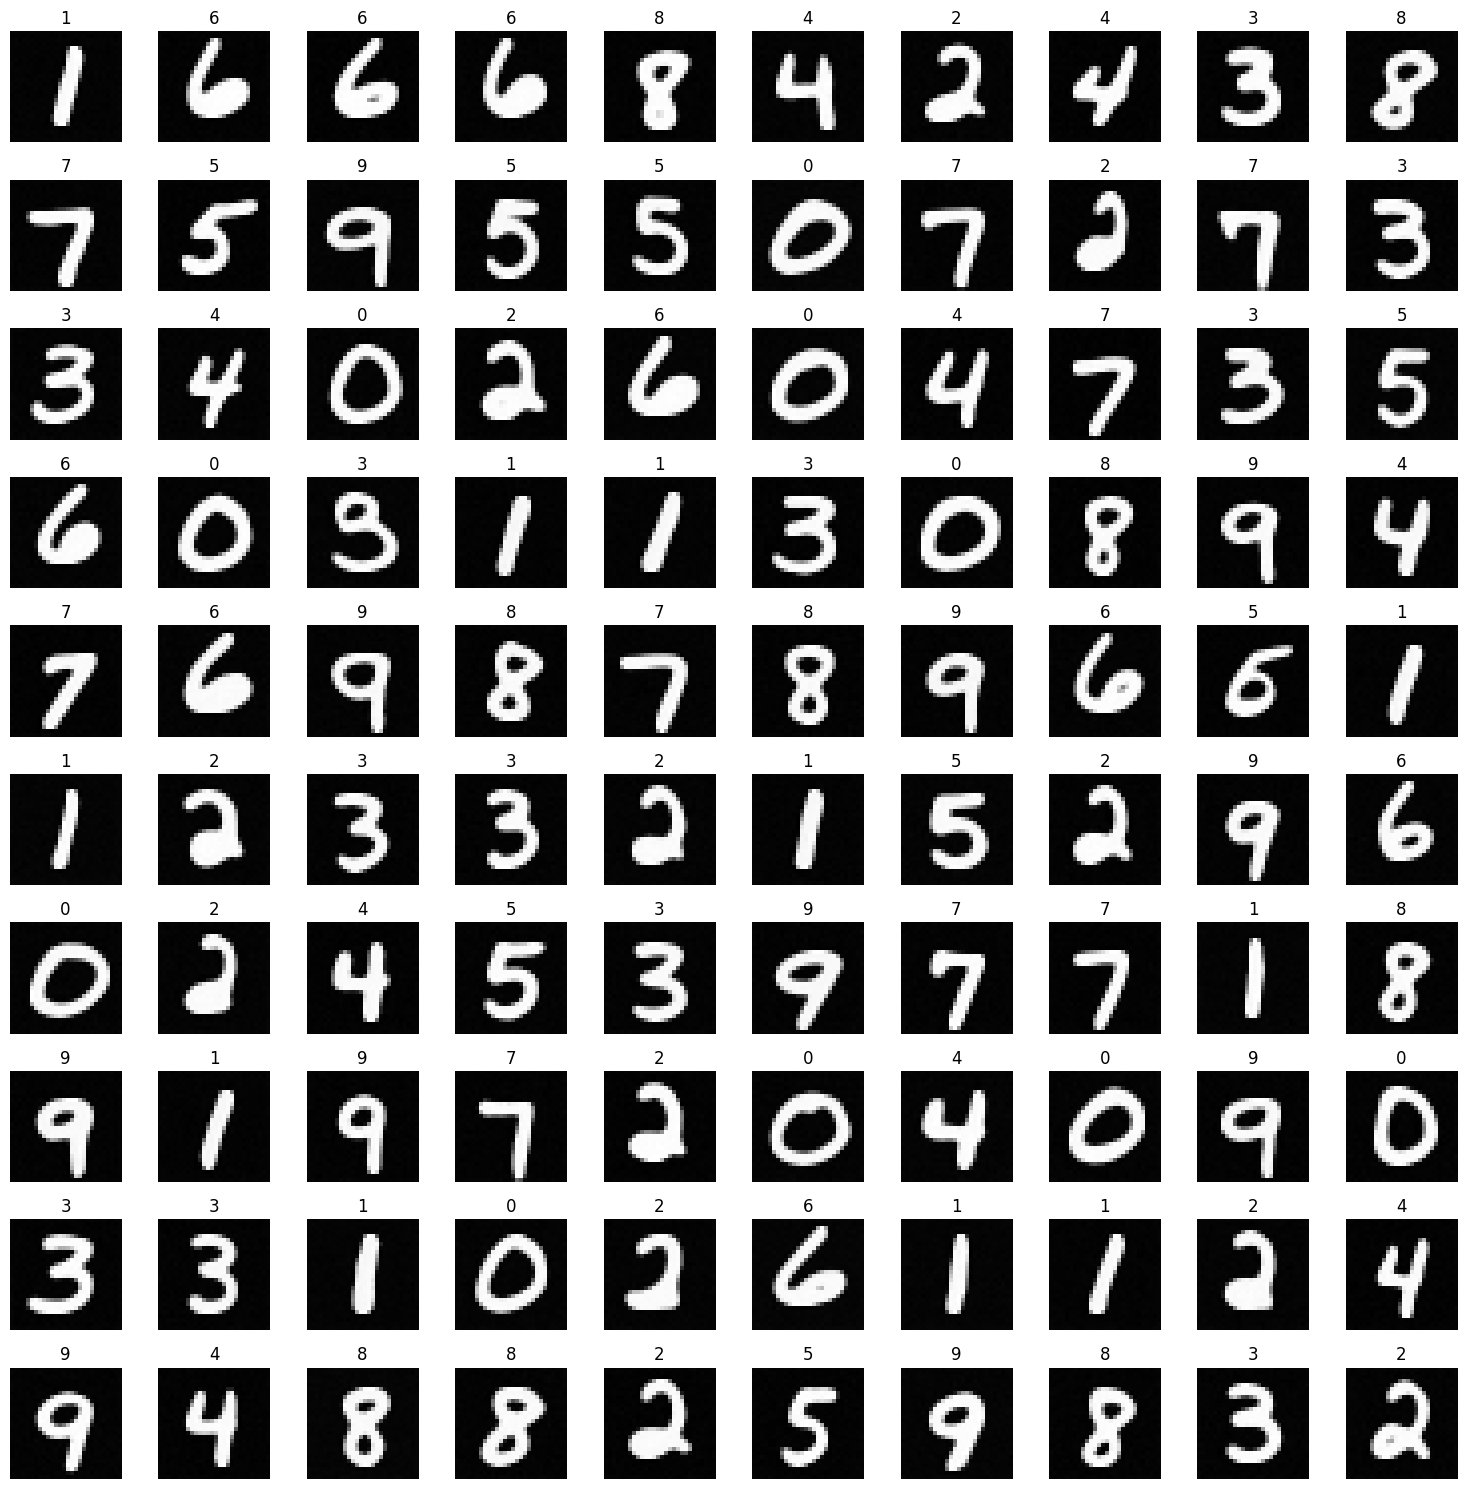

In [ ]:
t = -1  # timestep to display
rows = 9  # number of rows to display n_sample samples

batch = [x for x in rearrange(xs[t], 'b 1 h w -> b h w').cpu()]
classes = classes.cpu().tolist()

assert n_sample % rows == 0
cols = n_sample // rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2))

for i, ax in enumerate(axes.flatten()):
  ax.axis('off')
  ax.set_title(f'{classes[i]}')
  ax.imshow(batch[i], cmap='gray')

plt.tight_layout()
plt.show()

### Animate

In [ ]:
images = []
skip = 1  # skip these many timesteps to display
pad = transforms.Pad(2)
reshape = lambda x: pad(rearrange(pad(x), '(r s) 1 h w -> (r h) (s w)', r=rows))

start = max_t % skip
for x in ([xs[0]] if start else []) + xs[start::skip]:
  images.append(reshape(x).cpu().numpy())


def update(i):
  plt.clf()
  plt.imshow(images[i], cmap='plasma')
  plt.axis('off')


plt.ioff()
fig = plt.figure(figsize=(10, 10))
ani = animation.FuncAnimation(
  fig, update, frames=range(len(images)), interval=200
)

display(HTML(ani.to_jshtml()))

In [ ]:
plt.close()